In [1]:
#Restart kernel if rerunning this cell
import os 
wd = os.path.dirname(os.getcwd()).replace('\\', '/')
os.chdir(wd)

import pandas as pd
import geopandas as gpd
import scripts.preprocess_helper as ph
import scripts.cleanup_helper as ch
import scripts.overlay_map_helper as omh
import omegaconf
import warnings
import folium
import geopandas as gpd
from geocube.api.core import make_geocube

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
yaml_path = os.path.join(wd, 'conf', 'config.yaml')
cfg = omegaconf.OmegaConf.load(yaml_path)
paths = cfg.paths
consts = cfg.constants

In [3]:
cty_clean = gpd.read_parquet('data/boundaries/county_clean/county_clean.geoparquet')

In [4]:
cty_pop = gpd.read_parquet('data/population/cty_pop/cty_pop.geoparquet').to_crs('EPSG:3857')
tract_pop = gpd.read_parquet('data/population/tract_pop/tract_pop.geoparquet').to_crs('EPSG:3857')
coops = gpd.read_parquet('data/coops_utilities/rural_coops/rural_coops.geoparquet')
md_parquet = gpd.read_parquet('data/population/building_footprint/final_geoparquet/Maryland.geoparquet').to_crs('EPSG:3857')

<Axes: >

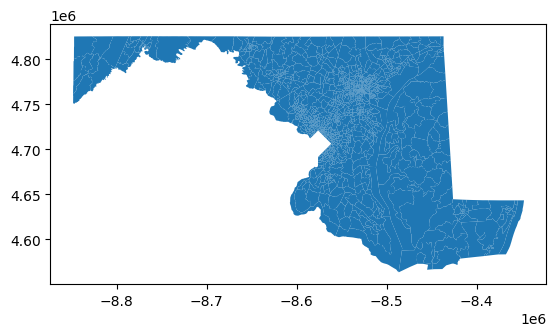

In [15]:
tract_pop[tract_pop['state']=='MD'].plot()

<Axes: >

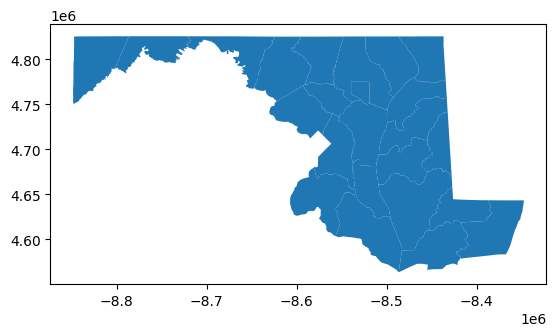

In [6]:
cty_pop[cty_pop['state']== 'MD'].plot()

#### Small sample test

In [5]:
md_pop = tract_pop.query('state == "MD"')
md_coops = coops.query('State == "Maryland"')

In [6]:
intersected_geometries = gpd.overlay(md_coops, md_pop, how='intersection')

In [7]:
spatial_idx = md_parquet.sindex
bbox = intersected_geometries.bounds.iloc[100].to_list()
possible_matches_index = list(spatial_idx.intersection(bbox))

In [8]:
possible_matches = md_parquet.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(intersected_geometries.iloc[100].geometry)]

In [9]:
from shapely import Polygon

minx, miny, maxx, maxy = bbox
coords = ((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny))
bounds_polygon = Polygon(coords)

bbox_gdf = gpd.GeoDataFrame(data={"geometry": [bounds_polygon]}, crs="EPSG:3857")
bbox_gdf

,geometry
0,"POLYGON ((-8443803.789 4807001.537, -8443803.7..."


In [ ]:
m = folium.Map()
folium.GeoJson(intersected_geometries).add_to(m)
folium.GeoJson(precise_matches, style_function=lambda c: {"color": "green", "fillColor":"green"}).add_to(m)
folium.GeoJson(bbox_gdf, style_function=lambda c: {"color": "red"}).add_to(m)
m

#### Testing on whole state

In [11]:
import tobler
from shapely.geometry import shape

# Initialize an empty dictionary to store the intersected building footprints and geometries for each county
tract_data = {}

# Loop through each county in md_pop
for idx, tract_row in md_pop.head(30).iterrows():
    tract_geometry = tract_row['geometry']
    tract_name = tract_row['tractName']
    intersected_geometries = md_coops[md_coops.geometry.intersects(tract_geometry)]
    if len(intersected_geometries) ==0:
        continue
    print(intersected_geometries.shape)
    spatial_idx = md_parquet.sindex
    bbox = intersected_geometries.bounds.iloc[0].to_list()
    possible_matches_index = list(spatial_idx.intersection(bbox))
    possible_matches = md_parquet.iloc[possible_matches_index]
    print(possible_matches.shape)
    precise_matches = possible_matches[possible_matches.intersects(intersected_geometries.iloc[0].geometry)]
    print(precise_matches.shape)
    # Perform area-weighted interpolation within the county
    interpolated_population = tobler.area_weighted.area_interpolate(
        source_df=tract_pop,
        target_df=precise_matches,
        extensive_variables=['total_pop'],
        allocate_total=True,
        n_jobs=-1
    )
    print(interpolated_population.shape)
    # Calculate the population within each coop in the tract by summing the interpolated population values over coops' geometries
    tract_population_data = {}
    for coop_name, coop_geometry in intersected_geometries.groupby('NAME')['geometry']:
        coop_population = interpolated_population[interpolated_population.geometry.intersects(coop_geometry)]['total_pop'].sum()
        tract_population_data[coop_name] = coop_population
    print(len(tract_population_data))
    # Store the county population data and geometry in the dictionary
    tract_data[tract_name] = {
        'geometry': tract_geometry,
        **tract_population_data
    }

# Convert the county_data dictionary into a DataFrame
tract_coop_df = pd.DataFrame.from_dict(tract_data, orient='index')
tract_coop_df.reset_index(inplace=True)
tract_coop_df.rename(columns={'index': 'tract'}, inplace=True)

(1, 35)
(264822, 3)
(129744, 3)
(129744, 2)
1


In [12]:
tract_coop_df

,tract,geometry,SOUTHERN MARYLAND ELEC COOP INC
0,"Census Tract 7013.01, Anne Arundel County, Mar...","POLYGON ((-8537696.54772963 4714256.814124986,...",0.504454


In [17]:
county_coop_df

,County,geometry,SOUTHERN MARYLAND ELEC COOP INC,"CHOPTANK ELECTRIC COOPERATIVE, INC"
0,"Allegany County, Maryland",POLYGON ((-8789229.950304952 4819013.830243661...,NaN,NaN
1,"Anne Arundel County, Maryland","POLYGON ((-8551134.48006074 4739080.047125726,...",1.72843,NaN
2,"Baltimore County, Maryland",POLYGON ((-8559055.084469665 4784967.567825314...,NaN,NaN
3,"Calvert County, Maryland",POLYGON ((-8537308.487984724 4676474.321936581...,1.72843,NaN
4,"Caroline County, Maryland",POLYGON ((-8448835.207606444 4695236.736019154...,NaN,0.567896
5,"Carroll County, Maryland","POLYGON ((-8593644.72192691 4804435.384902435,...",NaN,NaN
6,"Cecil County, Maryland",POLYGON ((-8453280.528832292 4825608.276970315...,NaN,0.567896
7,"Charles County, Maryland",POLYGON ((-8600065.518836377 4659312.257453384...,1.72843,NaN
8,"Dorchester County, Maryland",POLYGON ((-8457002.94128493 4669809.7997410325...,NaN,0.567896
9,"Frederick County, Maryland","POLYGON ((-8640637.79968733 4791339.705088571,...",NaN,NaN
